# Multinomial Naive Bayes

#### In this notebook, a Multinomial Naive Bayes model will be developed. The text data will be converted into a structured numeric dataframe using TF-IDF Vectorizer.

Importing libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

Loading and merging data:

In [2]:
crypto = pd.read_csv('../data/sub-crypto.csv')
eco = pd.read_csv('../data/sub-economics.csv')

# Merging bith together
data = crypto.append(eco)
data.head()

,subreddit,title
0,CryptoMarkets,Polychain and Celo Validator Community Bootstr...
1,CryptoMarkets,What's the Economics Of Public Goods ? :O
2,CryptoMarkets,Invesco pulls Bitcoin ETF application and othe...
3,CryptoMarkets,New York State Watchdog Orders Two Crypto Firm...
4,CryptoMarkets,New milestone: ProShares Bitcoin ETF goes publ...


In [3]:
data.shape

(20000, 2)

One hot encoding 'subreddit' column:

In [4]:
data['subreddit'].replace({'CryptoMarkets': 0, 'Economics': 1}, inplace = True)

# Displaying first 5 rows
data.head()

,subreddit,title
0,0,Polychain and Celo Validator Community Bootstr...
1,0,What's the Economics Of Public Goods ? :O
2,0,Invesco pulls Bitcoin ETF application and othe...
3,0,New York State Watchdog Orders Two Crypto Firm...
4,0,New milestone: ProShares Bitcoin ETF goes publ...


Shuffling the data:

In [5]:
# code from: https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
data = data.sample(frac = 1)

# Displaying first 5 rows
data.head()

,subreddit,title
4757,1,How are equilibrium prices determined in a mar...
9236,0,If you have not opened your vault I do highly ...
4466,1,‘Sizable’ stimulus needed from the United Stat...
6335,0,Bitcoin ATM Stolen During Raid In Barcelona Cr...
1243,0,How dare u


Defining matrixes and Train/Test splitting data:

In [6]:
X = data['title']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify = y,
                                                    random_state=42)

In [7]:
# Baseline score
y_test.value_counts(normalize=True)[0]

0.5

### Pipeline with  CountVectorizer and Multinomial Naive Bayes

In [9]:
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_cvec_params = {
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2)] #unigrams and bigrams
}

# Instantiate GridSearchCV.

gs_cvec = GridSearchCV(pipe_cvec, 
                        param_grid = pipe_cvec_params, 
                        cv=5, # 5-fold cross-validation
                        n_jobs=-1)

# Fit GridSearch to training data.
gs_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': ['english']})

Measuring performance:

In [10]:
gs_cvec.best_params_

{'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}

In [11]:
# Accuracy score model on training set.
gs_cvec.score(X_train, y_train)

0.9774626865671642

In [12]:
# Accuracy score model on testing set.
gs_cvec.score(X_test, y_test)

0.9096969696969697

Confusion Matrix:

In [13]:
# Predictions
preds_cvec = gs_cvec.predict(X_test)

# Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec).ravel()

# Specificity and precision

spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('Specificity:', spec)
print('Precision:', prec)

Specificity: 0.9257575757575758
Precision: 0.9232936756418284


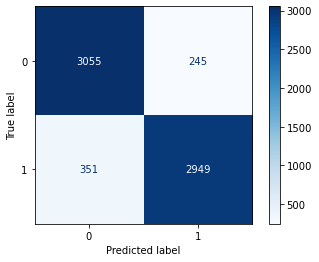

In [14]:
# visualize confusion matrix
plot_confusion_matrix(gs_cvec, X_test, y_test, cmap='Blues', values_format='d');

## Receiver Operating Characteristic (ROC) Curve

This curve helps us visualize our tradeoff between _sensitivity_ and _specificity_ and understand how well-separated our populations are.

### Interpreting ROC AUC
- If you have an ROC AUC of 0.5, your positive and negative populations perfectly overlap and your model is as bad as it can get.
- If you have an ROC AUC of 1, your positive and negative populations are perfectly separated and your model is as good as it can get.
- The closer your ROC AUC is to 1, the better. (1 is the maximum score.)
- If you have an ROC AUC of below 0.5, your positive and negative distributions have flipped sides.

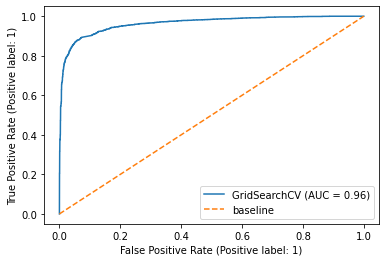

In [15]:
# ROC curve
plot_roc_curve(gs_cvec, X_test, y_test)

# Worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [16]:
# ROC AUC score
roc_auc_score(y_test, gs_cvec.predict_proba(X_test)[:, 1])

0.9635659320477502

### Pipeline with TF-IDF Vectorizer and Multinomial Naive Bayes

In [23]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tvec_params = {
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2)] #unigrams and bigrams
}

# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params, 
                        cv=5, # 5-fold cross-validation
                        n_jobs=-1)

# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': ['english']})

Measuring performance:

In [24]:
gs_tvec.best_params_

{'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}

In [25]:
# Accuracy score model on training set.
gs_tvec.score(X_train, y_train)

0.9773880597014926

In [26]:
# Accuracy score model on testing set.
gs_tvec.score(X_test, y_test)

0.901060606060606

Confusion Matrix:

In [27]:
# Predictions
preds_tvec = gs_tvec.predict(X_test)

# Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Specificity and precision

spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('Specificity:', spec)
print('Precision:', prec)

Specificity: 0.916969696969697
Precision: 0.9142410015649453


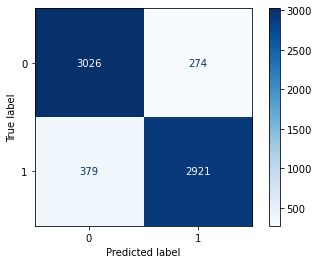

In [28]:
# visualize confusion matrix
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

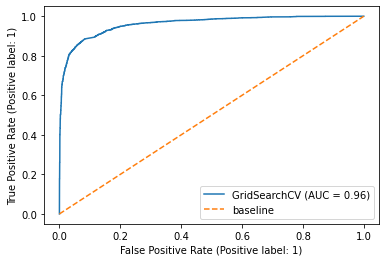

In [31]:
# ROC curve
plot_roc_curve(gs_tvec, X_test, y_test)

# Worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
plt.legend();

In [41]:
# ROC AUC score
roc_auc_score(y_test, gs_tvec.predict_proba(X_test)[:, 1])

0.9613488521579432